In [14]:
import pandas as pd
import os
import sys
import tensorflow as tf
sys.path.append(os.environ['CMS_ROOT'])
tf.__version__

'1.4.1'

In [42]:
from cms_modules.keras_callbacks import CustomMetricsCallback
from cms_modules.utils import train_valid_split_w_sampling, get_next_run_description, model_summary_to_string
from cms_modules.utils import get_imbalance_description, dict_to_hdf5, args_to_dict, get_class_weights
from cms_modules.plotting import plot_train_vs_validation

In [8]:
df = pd.read_hdf('./data/ecbdl14.onehot.sample.hdf', 'test')

In [9]:
df.shape

(700000, 201)

In [11]:
Keras = tf.contrib.keras

In [12]:
Sequential = Keras.models.Sequential
Dense, Dropout, BatchNorm = Keras.layers.Dense, Keras.layers.Dropout, Keras.layers.BatchNormalization

In [20]:
train_x, train_y, valid_x, valid_y = train_valid_split_w_sampling(
    df,
    valid_size=0.1,
    target_col='target',
    ros_rate=1,
    rus_rate=1)

In [25]:
model = Sequential()
model.add(Dense(128, input_dim=train_x.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               25728     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 34,049
Trainable params: 34,049
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [35]:
trainingMetricsCallback = CustomMetricsCallback(train_x.values, train_y.values, 5)
validationMetricsCallback = CustomMetricsCallback(valid_x.values, valid_y.values, 5, validation=True)

In [37]:
history = model.fit(
    x=train_x.values,
    y=train_y.values,
    epochs=10,
    batch_size=128,
    validation_data=(valid_x.values, valid_y.values),
    callbacks=[trainingMetricsCallback, validationMetricsCallback]
)

Train on 630000 samples, validate on 70000 samples
Epoch 1/10
628864/630000 [============================>.] - ETA: 0s - loss: 0.0729 - acc: 0.9799Epoch 0: Training Results
TN:  615884 	FP:  601
FN:  11825 	TP:  1690
AUC:  0.8990687187203311
Epoch 0: Validation Results
TN:  68407 	FP:  91
FN:  1466 	TP:  36
AUC:  0.7621921148941377
630000/630000 [==============================] - 31s - loss: 0.0729 - acc: 0.9799 - val_loss: 0.1004 - val_acc: 0.9778
Epoch 2/10
630000/630000 [==============================] - 16s - loss: 0.0716 - acc: 0.9802 - val_loss: 0.1009 - val_acc: 0.9775
Epoch 3/10
630000/630000 [==============================] - 16s - loss: 0.0705 - acc: 0.9804 - val_loss: 0.1032 - val_acc: 0.9759
Epoch 4/10
630000/630000 [==============================] - 16s - loss: 0.0692 - acc: 0.9806 - val_loss: 0.1030 - val_acc: 0.9771
Epoch 5/10
630000/630000 [==============================] - 16s - loss: 0.0681 - acc: 0.9809 - val_loss: 0.1051 - val_acc: 0.9769
Epoch 6/10
628736/630000 [=

In [38]:
training_scores = trainingMetricsCallback.get_scores()
validation_scores = trainingMetricsCallback.get_scores()
training_scores['loss'] = history.history['loss']
validation_scores['loss'] = history.history['val_loss']

TypeError: 'NoneType' object is not iterable

<Figure size 432x288 with 0 Axes>

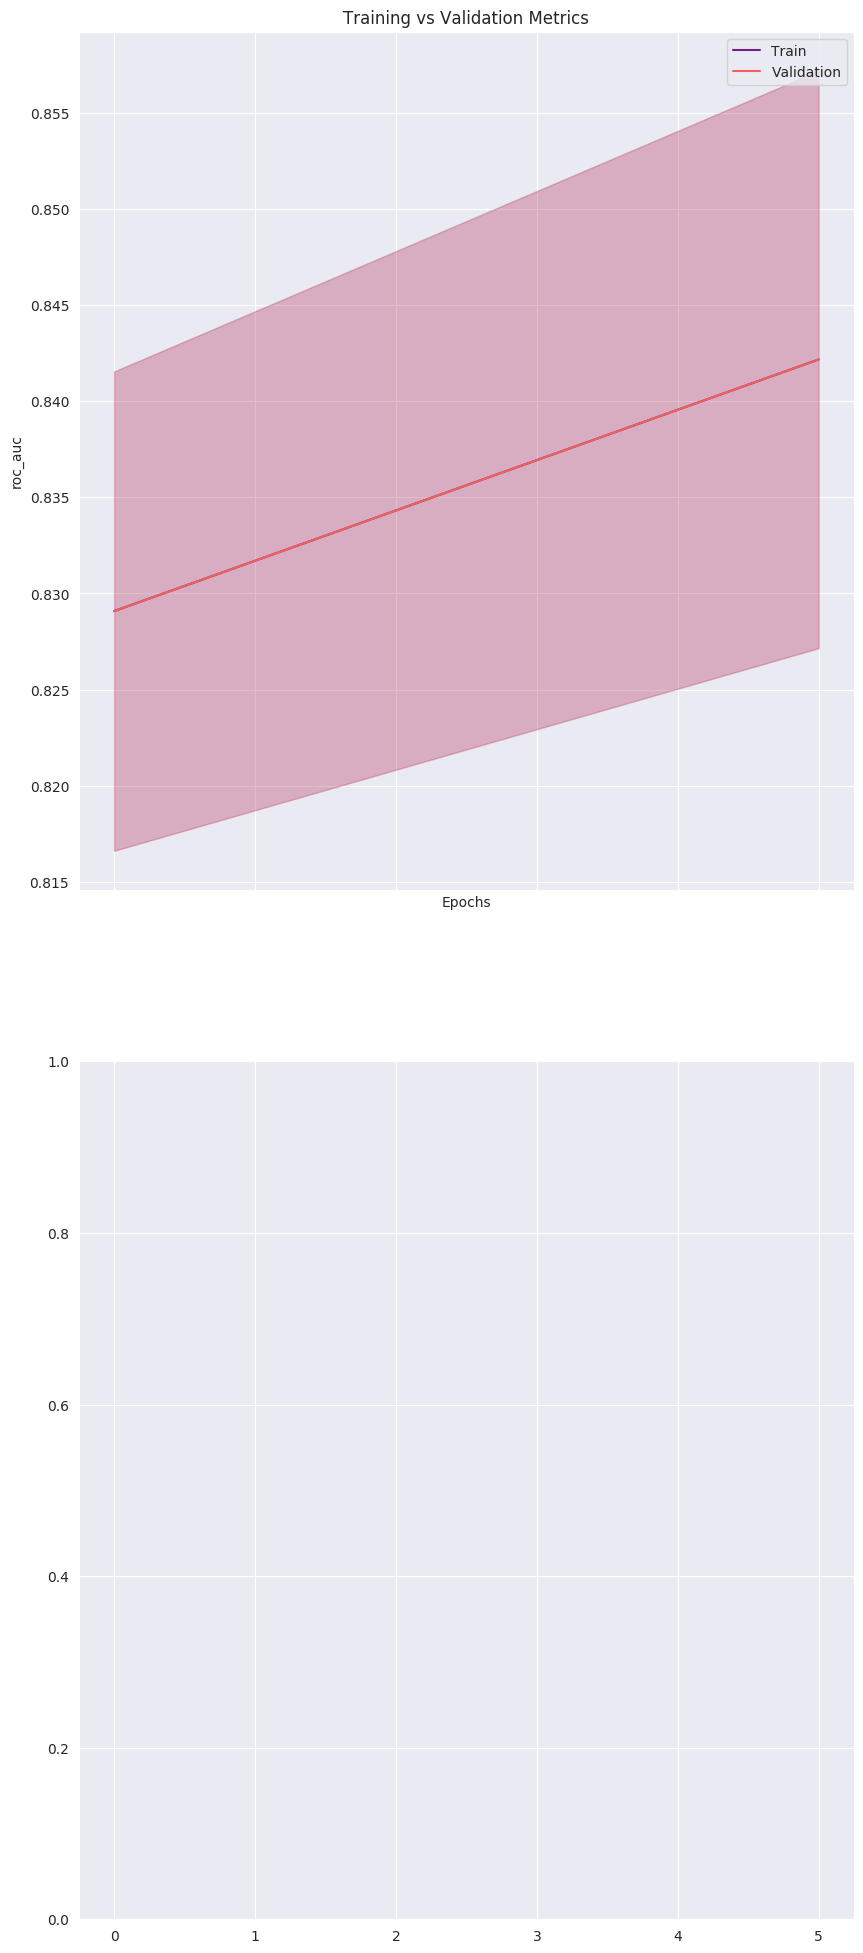

In [46]:
metrics_to_plot=['roc_auc', 'gmean']
plot_train_vs_validation(metrics_to_plot, training_scores, validation_scores, 'testrun_20epoch_gpu.png')